In [1]:
import glob
import os

from tqdm import tqdm_notebook as tqdm

import numpy as np
import pandas as pd
import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.datasets import cifar10, cifar100
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# CIFAR 10 Information
class_num = 10
img_size = 32
ch_num = 3

# The data, shuffled and split between train and test sets:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
# Convert class vectors to binary class matrices.
Y_train = to_categorical(y_train, class_num)
Y_test = to_categorical(y_test, class_num)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# subtract mean and normalize
mean_image = np.mean(X_train)
X_train -= mean_image
X_test -= mean_image
X_train /= 128.
X_test /= 128.

In [4]:
 # random crop shift range
shift_range = 0.3
expand_target_size = int(img_size*(shift_range+1))
def image_shift(image):
    # padding
    image = tf.image.resize_with_crop_or_pad(
                    image,
                    expand_target_size,
                    expand_target_size
                    )
    #random crop
    image = tf.image.random_crop(
                    image,
                    size=[img_size, img_size, ch_num]
                    )
    return image

def flip_image(image):
    return tf.image.random_flip_left_right(image)

In [5]:
def data_balance(labels,data_num):
    """data choice function for label balanced data
    """
    labels_dic = {}
    ids = np.arange(labels.shape[0])
    for label in range(len(np.unique(labels))):
        label_choice = ids[labels==label]
        shfl = np.random.choice(label_choice.shape[0], data_num, replace=False)
        labels_dic[label] = label_choice[shfl]
    data_choice = np.concatenate([labels_dic[label] for label in labels_dic.keys()],axis=0)
    shfl = np.random.choice(data_choice.shape[0],data_choice.shape[0],replace=False)
    data_choice = data_choice[shfl]

    # check
    shfl_labels = labels[data_choice]
    assert len(np.unique(shfl_labels)) == len(np.unique(labels))
    assert (np.unique(shfl_labels,return_counts=True)[1] == data_num).all()

    return data_choice

In [6]:
choice = data_balance(y_train.reshape(-1),data_num=Y_test.shape[0]//class_num)
X_train_eval = X_train[choice]
Y_train_eval = Y_train[choice]
np.sum(Y_train_eval,axis=0)

array([1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
       1000.], dtype=float32)

# Adaptive LR decay

In [7]:
class training_model():
    def __init__(self,X_train,Y_train, X_train_eval, Y_train_eval, X_test,Y_test, batch_size=32):

        self.model = tf.keras.applications.VGG16(input_shape=(32,32,3),weights=None,classes=class_num) 
        self.model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
        self.model.summary()
        #self.model_vals = self.model.trainable_variables
        self.batch_size = batch_size
        self.create_dataset(X_train,Y_train, X_train_eval, Y_train_eval, X_test,Y_test)


    def create_dataset(self, X_train,Y_train, X_train_eval, Y_train_eval, X_test,Y_test):
        # create train dataset 
        input_ds = tf.data.Dataset.from_tensor_slices(X_train)
        input_ds = input_ds.map(flip_image,num_parallel_calls=tf.data.experimental.AUTOTUNE).map(image_shift,num_parallel_calls=tf.data.experimental.AUTOTUNE)
        target_ds = tf.data.Dataset.from_tensor_slices(Y_train)
        train_ds = tf.data.Dataset.zip((input_ds, target_ds)).batch(self.batch_size).repeat()
        self.train_iter = iter(train_ds)
        self.train_batch_num = int(np.ceil(X_train.shape[0]/self.batch_size))

        # crate train dataset for eval
        input_ds = tf.data.Dataset.from_tensor_slices(X_train_eval)
        target_ds = tf.data.Dataset.from_tensor_slices(Y_train_eval)
        self.train_e_ds = tf.data.Dataset.zip((input_ds, target_ds)).batch(self.batch_size).repeat()
        self.train_e_batch_num = int(np.ceil(X_train_eval.shape[0]/self.batch_size))

        # create test
        input_ds = tf.data.Dataset.from_tensor_slices(X_test)
        target_ds = tf.data.Dataset.from_tensor_slices(Y_test)
        self.test_ds = tf.data.Dataset.zip((input_ds, target_ds)).batch(self.batch_size).repeat()    
        self.test_batch_num =  int(np.ceil(X_test.shape[0]/self.batch_size))
    
    
    def create_train_step(self,lr):
        #self.optimizer =  tfa.optimizers.RectifiedAdam(lr)
        self.optimizer =  tf.keras.optimizers.SGD(lr)
        self.model_vals = self.model.trainable_variables
        
        @tf.function
        def train_step(b_input, b_target):
            with tf.GradientTape() as tape:
                preds= self.model(b_input)
                loss = categorical_crossentropy(b_target,preds)
            grads = tape.gradient(loss, self.model_vals)
            self.optimizer.apply_gradients(zip(grads, self.model_vals))
        return train_step
        
        
    def minibatch_training(self):
            b_input, b_target = next(self.train_iter)
            self.train_step(b_input,b_target)
                
                       
    def train(self,
                    epochs=200, 
                    max_patience=10, 
                    decay_patience = 6, # patience　of lr decay
                    num_decay = 3, 
                    decay_ratio = 4, 
                    default_lr = 0.001, # default Learning rate
                    ):
        
        acc_history = [] # valid loss history
        patience=0 # early stop patience
        if num_decay>0:
            _max_patience = decay_patience
        else:
            _max_patience = max_patience
        
        #First Evaluation
        print("First_evaluation")
        [train_loss, train_acc] = self.model.evaluate(self.train_e_ds,steps=self.train_e_batch_num, verbose=1)
        [valid_loss, valid_acc] = self.model.evaluate(self.test_ds,steps=self.test_batch_num, verbose=1)
        best_train_losses = [train_loss, train_acc]
        best_valid_losses = [valid_loss, valid_acc]
        acc_history.append(valid_acc)
        max_acc = valid_acc
        print("epoch:",0,"-----",end="")
        print("train loss :",round(train_loss, 4), ",train acc: ",round(train_acc, 4),end="")
        print(",  valid loss :",round(valid_loss, 4), ",vaild acc: ",round(valid_acc, 4))
        print("batch num ",self.train_batch_num)
        # start training
        lr = default_lr
        self.train_step = self.create_train_step(lr)
        for epoch in range(epochs):
           
            for batch in tqdm(range(self.train_batch_num)):
                self.minibatch_training() # minibatch training
                
            # evaluation at epoch end
            [train_loss, train_acc]  = self.model.evaluate(self.train_e_ds,steps=self.train_e_batch_num, verbose=0)
            [valid_loss, valid_acc] = self.model.evaluate(self.test_ds,steps=self.test_batch_num, verbose=0)
            acc_history.append(valid_acc)
            print("epoch:",epoch+1,"-----",end="")
            print("train loss :",round(train_loss, 4), ",train acc: ",round(train_acc, 4),end="")
            print(",  valid loss :",round(valid_loss, 4), ",vaild acc: ",round(valid_acc, 4),end="")
            
            if max_acc < valid_acc:
                self.model.save(os.path.join("./model.h5", ))
                best_train_losses = [train_loss, train_acc]
                best_valid_losses = [valid_loss, valid_acc]
                max_acc = valid_acc
                patience=0
                print("     accuracy improved!")
            else:
                patience+=1
                print("")
                
            # early stopping
            if patience>_max_patience:
                num_decay -= 1
                if num_decay<=0:
                    break
                else:
                    self.model = tf.keras.models.load_model("./model.h5")
                    print("--------------------------------------")
                    print ("Learning Rate Decay : ",lr,"->",end="")
                    lr = lr/decay_ratio
                    print(lr)
                    print("--------------------------------------")
                    del self.train_step
                    self.train_step = self.create_train_step(lr)
                    patience=0
                    if num_decay==1:
                        _max_patience=max_patience
                
        print("-------------------------------")
        print("Training Results at best validation loss")
        print("train loss :",round(best_train_losses[0], 4), ",train acc: ",round(best_train_losses[1], 4),end="")
        print(",  valid loss :",round(best_valid_losses[0], 4), ",vaild acc: ",round(best_valid_losses[1], 4))
        
        return acc_history, [best_train_losses,best_valid_losses]

In [8]:
Train = training_model(X_train,Y_train, X_train_eval, Y_train_eval, X_test,Y_test, batch_size=16)
acc_history_LR, [best_train_losses,best_valid_losses] = Train.train(decay_patience=3)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:89: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



epoch: 1 -----train loss : 2.2377 ,train acc:  0.1603,  valid loss : 2.2359 ,vaild acc:  0.1626     accuracy improved!



epoch: 2 -----train loss : 1.8442 ,train acc:  0.2654,  valid loss : 1.842 ,vaild acc:  0.2671     accuracy improved!



epoch: 3 -----train loss : 1.8337 ,train acc:  0.3066,  valid loss : 1.8192 ,vaild acc:  0.3061     accuracy improved!



epoch: 4 -----train loss : 1.3859 ,train acc:  0.4742,  valid loss : 1.3902 ,vaild acc:  0.4715     accuracy improved!



epoch: 5 -----train loss : 1.3674 ,train acc:  0.5074,  valid loss : 1.3776 ,vaild acc:  0.5063     accuracy improved!



epoch: 6 -----train loss : 1.0539 ,train acc:  0.6178,  valid loss : 1.0843 ,vaild acc:  0.6092     accuracy improved!



epoch: 7 -----train loss : 0.9188 ,train acc:  0.6729,  valid loss : 0.9556 ,vaild acc:  0.6637     accuracy improved!



epoch: 8 -----train loss : 0.8294 ,train acc:  0.7114,  valid loss : 0.8704 ,vaild acc:  0.6973     accuracy improved!



epoch: 9 -----train loss : 0.7489 ,train acc:  0.7431,  valid loss : 0.7904 ,vaild acc:  0.7333     accuracy improved!



epoch: 10 -----train loss : 0.6523 ,train acc:  0.774,  valid loss : 0.7219 ,vaild acc:  0.7571     accuracy improved!



epoch: 11 -----train loss : 0.607 ,train acc:  0.7952,  valid loss : 0.6724 ,vaild acc:  0.7725     accuracy improved!



epoch: 12 -----train loss : 0.5349 ,train acc:  0.8153,  valid loss : 0.6113 ,vaild acc:  0.795     accuracy improved!



epoch: 13 -----train loss : 0.4659 ,train acc:  0.8411,  valid loss : 0.5531 ,vaild acc:  0.8131     accuracy improved!



epoch: 14 -----train loss : 0.4676 ,train acc:  0.8462,  valid loss : 0.5669 ,vaild acc:  0.8123



epoch: 15 -----train loss : 0.4423 ,train acc:  0.8489,  valid loss : 0.5664 ,vaild acc:  0.8168     accuracy improved!



epoch: 16 -----train loss : 0.3808 ,train acc:  0.8745,  valid loss : 0.5186 ,vaild acc:  0.8288     accuracy improved!



epoch: 17 -----train loss : 0.3423 ,train acc:  0.8826,  valid loss : 0.4797 ,vaild acc:  0.8412     accuracy improved!



epoch: 18 -----train loss : 0.3228 ,train acc:  0.8918,  valid loss : 0.4746 ,vaild acc:  0.8447     accuracy improved!



epoch: 19 -----train loss : 0.321 ,train acc:  0.8911,  valid loss : 0.4931 ,vaild acc:  0.8401



epoch: 20 -----train loss : 0.2978 ,train acc:  0.8986,  valid loss : 0.4831 ,vaild acc:  0.844



epoch: 21 -----train loss : 0.2668 ,train acc:  0.9115,  valid loss : 0.4586 ,vaild acc:  0.8548     accuracy improved!



epoch: 22 -----train loss : 0.2549 ,train acc:  0.9142,  valid loss : 0.4649 ,vaild acc:  0.8534



epoch: 23 -----train loss : 0.2566 ,train acc:  0.915,  valid loss : 0.4745 ,vaild acc:  0.8543



epoch: 24 -----train loss : 0.2373 ,train acc:  0.9162,  valid loss : 0.4566 ,vaild acc:  0.858     accuracy improved!



epoch: 25 -----train loss : 0.2085 ,train acc:  0.9297,  valid loss : 0.4367 ,vaild acc:  0.8651     accuracy improved!



epoch: 26 -----train loss : 0.2304 ,train acc:  0.9227,  valid loss : 0.4622 ,vaild acc:  0.8555



epoch: 27 -----train loss : 0.2025 ,train acc:  0.9303,  valid loss : 0.447 ,vaild acc:  0.861



epoch: 28 -----train loss : 0.1878 ,train acc:  0.9354,  valid loss : 0.4411 ,vaild acc:  0.8615



epoch: 29 -----train loss : 0.2439 ,train acc:  0.921,  valid loss : 0.5524 ,vaild acc:  0.8456
--------------------------------------
Learning Rate Decay :  0.001 ->0.00025
--------------------------------------



epoch: 30 -----train loss : 0.1432 ,train acc:  0.9518,  valid loss : 0.411 ,vaild acc:  0.8772     accuracy improved!



epoch: 31 -----train loss : 0.1305 ,train acc:  0.9562,  valid loss : 0.4168 ,vaild acc:  0.88     accuracy improved!



epoch: 32 -----train loss : 0.1148 ,train acc:  0.9598,  valid loss : 0.4245 ,vaild acc:  0.8809     accuracy improved!



epoch: 33 -----train loss : 0.0981 ,train acc:  0.9677,  valid loss : 0.4227 ,vaild acc:  0.8836     accuracy improved!



epoch: 34 -----train loss : 0.0969 ,train acc:  0.9672,  valid loss : 0.424 ,vaild acc:  0.885     accuracy improved!



epoch: 35 -----train loss : 0.0912 ,train acc:  0.9711,  valid loss : 0.4277 ,vaild acc:  0.8862     accuracy improved!



epoch: 36 -----train loss : 0.0859 ,train acc:  0.9703,  valid loss : 0.4516 ,vaild acc:  0.8788



epoch: 37 -----train loss : 0.082 ,train acc:  0.9728,  valid loss : 0.4578 ,vaild acc:  0.8818



epoch: 38 -----train loss : 0.089 ,train acc:  0.9684,  valid loss : 0.4764 ,vaild acc:  0.8794



epoch: 39 -----train loss : 0.0759 ,train acc:  0.9746,  valid loss : 0.4617 ,vaild acc:  0.8808
--------------------------------------
Learning Rate Decay :  0.00025 ->6.25e-05
--------------------------------------



epoch: 40 -----train loss : 0.0779 ,train acc:  0.9751,  valid loss : 0.4274 ,vaild acc:  0.8875     accuracy improved!



epoch: 41 -----train loss : 0.0734 ,train acc:  0.9757,  valid loss : 0.4363 ,vaild acc:  0.8885     accuracy improved!



epoch: 42 -----train loss : 0.0705 ,train acc:  0.9758,  valid loss : 0.4353 ,vaild acc:  0.8911     accuracy improved!



epoch: 43 -----train loss : 0.0674 ,train acc:  0.9778,  valid loss : 0.4436 ,vaild acc:  0.8894



epoch: 44 -----train loss : 0.0655 ,train acc:  0.9769,  valid loss : 0.4411 ,vaild acc:  0.8881



epoch: 45 -----train loss : 0.0647 ,train acc:  0.9782,  valid loss : 0.4462 ,vaild acc:  0.8894



epoch: 46 -----train loss : 0.0602 ,train acc:  0.9803,  valid loss : 0.4569 ,vaild acc:  0.8884



epoch: 47 -----train loss : 0.06 ,train acc:  0.9796,  valid loss : 0.4654 ,vaild acc:  0.8902



epoch: 48 -----train loss : 0.0566 ,train acc:  0.9803,  valid loss : 0.4681 ,vaild acc:  0.8889



epoch: 49 -----train loss : 0.0548 ,train acc:  0.9804,  valid loss : 0.4709 ,vaild acc:  0.8913     accuracy improved!



epoch: 50 -----train loss : 0.0529 ,train acc:  0.9809,  valid loss : 0.4728 ,vaild acc:  0.8884



epoch: 51 -----train loss : 0.0509 ,train acc:  0.982,  valid loss : 0.4737 ,vaild acc:  0.8915     accuracy improved!



epoch: 52 -----train loss : 0.0498 ,train acc:  0.9835,  valid loss : 0.4788 ,vaild acc:  0.8881



epoch: 53 -----train loss : 0.0496 ,train acc:  0.9828,  valid loss : 0.4838 ,vaild acc:  0.8889



epoch: 54 -----train loss : 0.0466 ,train acc:  0.9848,  valid loss : 0.489 ,vaild acc:  0.8885



epoch: 55 -----train loss : 0.0465 ,train acc:  0.9835,  valid loss : 0.4956 ,vaild acc:  0.8895



epoch: 56 -----train loss : 0.0436 ,train acc:  0.9844,  valid loss : 0.4986 ,vaild acc:  0.8886



epoch: 57 -----train loss : 0.0424 ,train acc:  0.9859,  valid loss : 0.5018 ,vaild acc:  0.8888



epoch: 58 -----train loss : 0.0434 ,train acc:  0.9849,  valid loss : 0.5114 ,vaild acc:  0.8888



epoch: 59 -----train loss : 0.0408 ,train acc:  0.9853,  valid loss : 0.5073 ,vaild acc:  0.8886



epoch: 60 -----train loss : 0.0369 ,train acc:  0.9872,  valid loss : 0.5035 ,vaild acc:  0.8904



epoch: 61 -----train loss : 0.0347 ,train acc:  0.9886,  valid loss : 0.5081 ,vaild acc:  0.8904



epoch: 62 -----train loss : 0.0345 ,train acc:  0.988,  valid loss : 0.5212 ,vaild acc:  0.8888
-------------------------------
Training Results at best validation loss
train loss : 0.0509 ,train acc:  0.982,  valid loss : 0.4737 ,vaild acc:  0.8915


(0.75, 1.0)

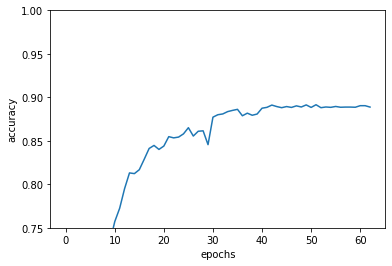

In [9]:
plt.plot(acc_history_LR)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim((0.75,1.0))

In [10]:
class training_model():
    def __init__(self,X_train,Y_train, X_train_eval, Y_train_eval, X_test,Y_test, batch_size=16):

        self.model = tf.keras.applications.VGG16(input_shape=(32,32,3),weights=None,classes=class_num) 
        self.model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
        self.model.summary()
        #self.model_vals = self.model.trainable_variables
        self.batch_size = batch_size
        self.create_dataset(X_train,Y_train, X_train_eval, Y_train_eval, X_test,Y_test)


    def create_dataset(self, X_train,Y_train, X_train_eval, Y_train_eval, X_test,Y_test):
        # create train dataset 
        input_ds = tf.data.Dataset.from_tensor_slices(X_train)
        input_ds = input_ds.map(flip_image,num_parallel_calls=tf.data.experimental.AUTOTUNE).map(image_shift,num_parallel_calls=tf.data.experimental.AUTOTUNE)
        target_ds = tf.data.Dataset.from_tensor_slices(Y_train)
        self.train_ds = tf.data.Dataset.zip((input_ds, target_ds)).batch(self.batch_size).repeat()
        self.train_iter = iter(self.train_ds)
        self.train_batch_num = int(np.ceil(X_train.shape[0]/self.batch_size))

        # crate train dataset for eval
        input_ds = tf.data.Dataset.from_tensor_slices(X_train_eval)
        target_ds = tf.data.Dataset.from_tensor_slices(Y_train_eval)
        self.train_e_ds = tf.data.Dataset.zip((input_ds, target_ds)).batch(self.batch_size).repeat()
        self.train_e_batch_num = int(np.ceil(X_train_eval.shape[0]/self.batch_size))

        # create test
        input_ds = tf.data.Dataset.from_tensor_slices(X_test)
        target_ds = tf.data.Dataset.from_tensor_slices(Y_test)
        self.test_ds = tf.data.Dataset.zip((input_ds, target_ds)).batch(self.batch_size).repeat()    
        self.test_batch_num =  int(np.ceil(X_test.shape[0]/self.batch_size))
    
    
    def create_train_step(self,lr):
        self.optimizer =  tf.keras.optimizers.SGD(lr)
        self.model_vals = self.model.trainable_variables
        self.train_iter = iter(self.train_ds.unbatch().batch(self.batch_size))
        
        @tf.function
        def train_step(b_input, b_target):
            with tf.GradientTape() as tape:
                preds= self.model(b_input)
                loss = categorical_crossentropy(b_target,preds)
            grads = tape.gradient(loss, self.model_vals)
            self.optimizer.apply_gradients(zip(grads, self.model_vals))
        return train_step
        
        
    def minibatch_training(self):
            b_input, b_target = next(self.train_iter)
            self.train_step(b_input,b_target)
            
                
                
    def train(self,
                    epochs=200, 
                    max_patience=10, 
                    decay_patience = 6, # lr decayをかけるときのpatience
                    num_decay = 3, 
                    decay_ratio = 4, 
                    default_lr = 0.001, # default Learning rate
                    ):
        
        acc_history = [] # valid loss history
        patience=0 # early stop patience
        if num_decay>0:
            _max_patience = decay_patience
        else:
            _max_patience = max_patience
        
        #First Evaluation
        print("First_evaluation")
        [train_loss, train_acc] = self.model.evaluate(self.train_e_ds,steps=self.train_e_batch_num, verbose=1)
        [valid_loss, valid_acc] = self.model.evaluate(self.test_ds,steps=self.test_batch_num, verbose=1)
        best_train_losses = [train_loss, train_acc]
        best_valid_losses = [valid_loss, valid_acc]
        acc_history.append(valid_acc)
        max_acc = valid_acc
        print("epoch:",0,"-----",end="")
        print("train loss :",round(train_loss, 4), ",train acc: ",round(train_acc, 4),end="")
        print(",  valid loss :",round(valid_loss, 4), ",vaild acc: ",round(valid_acc, 4))
        print("batch num ",self.train_batch_num)
        # start training
        lr = default_lr
        self.train_step = self.create_train_step(lr)
        for epoch in range(epochs):
           
            for batch in tqdm(range(self.train_batch_num)):
                self.minibatch_training() # minibatch training
                
            # evaluation at epoch end
            [train_loss, train_acc]  = self.model.evaluate(self.train_e_ds,steps=self.train_e_batch_num, verbose=0)
            [valid_loss, valid_acc] = self.model.evaluate(self.test_ds,steps=self.test_batch_num, verbose=0)
            acc_history.append(valid_acc)
            print("epoch:",epoch+1,"-----",end="")
            print("train loss :",round(train_loss, 4), ",train acc: ",round(train_acc, 4),end="")
            print(",  valid loss :",round(valid_loss, 4), ",vaild acc: ",round(valid_acc, 4),end="")
            
            if max_acc < valid_acc:
                self.model.save(os.path.join("./model.h5", ))
                best_train_losses = [train_loss, train_acc]
                best_valid_losses = [valid_loss, valid_acc]
                max_acc = valid_acc
                patience=0
                print("     accuracy improved!")
            else:
                patience+=1
                print("")
                
            # early stopping
            if patience>_max_patience:
                num_decay -= 1
                if num_decay<=0:
                    break
                else:
                    #del self.train_step
                    self.model = tf.keras.models.load_model("./model.h5")

                    print("--------------------------------------")
                    print ("Batch size increasing : ",self.batch_size,"->",end="")
                    self.batch_size = self.batch_size*decay_ratio
                    print(self.batch_size)
                    print("--------------------------------------")
                    self.train_step = self.create_train_step(lr)
                    
                    patience=0
                    if num_decay==1:
                        _max_patience=max_patience
                
        print("-------------------------------")
        print("Training Results at best validation loss")
        print("train loss :",round(best_train_losses[0], 4), ",train acc: ",round(best_train_losses[1], 4),end="")
        print(",  valid loss :",round(best_valid_losses[0], 4), ",vaild acc: ",round(best_valid_losses[1], 4))
        
        return acc_history, [best_train_losses,best_valid_losses]

In [11]:
Train = training_model(X_train,Y_train, X_train_eval, Y_train_eval, X_test,Y_test, batch_size=16)
acc_history_BS, [best_train_losses,best_valid_losses] = Train.train(decay_patience=3)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:90: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



epoch: 1 -----train loss : 2.0775 ,train acc:  0.1959,  valid loss : 2.0804 ,vaild acc:  0.1969     accuracy improved!



epoch: 2 -----train loss : 1.8771 ,train acc:  0.2602,  valid loss : 1.8706 ,vaild acc:  0.2597     accuracy improved!



epoch: 3 -----train loss : 1.6808 ,train acc:  0.354,  valid loss : 1.6744 ,vaild acc:  0.355     accuracy improved!



epoch: 4 -----train loss : 1.3833 ,train acc:  0.4772,  valid loss : 1.3923 ,vaild acc:  0.4731     accuracy improved!



epoch: 5 -----train loss : 1.224 ,train acc:  0.5434,  valid loss : 1.2511 ,vaild acc:  0.5339     accuracy improved!



epoch: 6 -----train loss : 1.0523 ,train acc:  0.6188,  valid loss : 1.0711 ,vaild acc:  0.6122     accuracy improved!



epoch: 7 -----train loss : 0.9594 ,train acc:  0.6566,  valid loss : 0.9877 ,vaild acc:  0.6472     accuracy improved!



epoch: 8 -----train loss : 0.8665 ,train acc:  0.6876,  valid loss : 0.9026 ,vaild acc:  0.6806     accuracy improved!



epoch: 9 -----train loss : 0.724 ,train acc:  0.7478,  valid loss : 0.7748 ,vaild acc:  0.7317     accuracy improved!



epoch: 10 -----train loss : 0.6486 ,train acc:  0.7789,  valid loss : 0.7116 ,vaild acc:  0.7576     accuracy improved!



epoch: 11 -----train loss : 0.5942 ,train acc:  0.7984,  valid loss : 0.6689 ,vaild acc:  0.7727     accuracy improved!



epoch: 12 -----train loss : 0.5424 ,train acc:  0.8175,  valid loss : 0.6283 ,vaild acc:  0.7906     accuracy improved!



epoch: 13 -----train loss : 0.4825 ,train acc:  0.8349,  valid loss : 0.5761 ,vaild acc:  0.8082     accuracy improved!



epoch: 14 -----train loss : 0.4398 ,train acc:  0.8487,  valid loss : 0.5533 ,vaild acc:  0.8156     accuracy improved!



epoch: 15 -----train loss : 0.4196 ,train acc:  0.8606,  valid loss : 0.5438 ,vaild acc:  0.8212     accuracy improved!



epoch: 16 -----train loss : 0.3838 ,train acc:  0.8708,  valid loss : 0.5197 ,vaild acc:  0.8281     accuracy improved!



epoch: 17 -----train loss : 0.3862 ,train acc:  0.8675,  valid loss : 0.5359 ,vaild acc:  0.8252



epoch: 18 -----train loss : 0.3276 ,train acc:  0.8908,  valid loss : 0.4793 ,vaild acc:  0.8456     accuracy improved!



epoch: 19 -----train loss : 0.3165 ,train acc:  0.8943,  valid loss : 0.4872 ,vaild acc:  0.8476     accuracy improved!



epoch: 20 -----train loss : 0.3019 ,train acc:  0.8958,  valid loss : 0.4717 ,vaild acc:  0.8484     accuracy improved!



epoch: 21 -----train loss : 0.2806 ,train acc:  0.9049,  valid loss : 0.4782 ,vaild acc:  0.8497     accuracy improved!



epoch: 22 -----train loss : 0.2784 ,train acc:  0.901,  valid loss : 0.4823 ,vaild acc:  0.8488



epoch: 23 -----train loss : 0.2558 ,train acc:  0.9138,  valid loss : 0.4862 ,vaild acc:  0.8467



epoch: 24 -----train loss : 0.2393 ,train acc:  0.9188,  valid loss : 0.4687 ,vaild acc:  0.8543     accuracy improved!



epoch: 25 -----train loss : 0.2433 ,train acc:  0.9183,  valid loss : 0.4897 ,vaild acc:  0.8521



epoch: 26 -----train loss : 0.2265 ,train acc:  0.9244,  valid loss : 0.4876 ,vaild acc:  0.853



epoch: 27 -----train loss : 0.198 ,train acc:  0.9319,  valid loss : 0.4596 ,vaild acc:  0.8588     accuracy improved!



epoch: 28 -----train loss : 0.1851 ,train acc:  0.9369,  valid loss : 0.4569 ,vaild acc:  0.867     accuracy improved!



epoch: 29 -----train loss : 0.1925 ,train acc:  0.9343,  valid loss : 0.4493 ,vaild acc:  0.8589



epoch: 30 -----train loss : 0.1829 ,train acc:  0.9374,  valid loss : 0.4629 ,vaild acc:  0.8623



epoch: 31 -----train loss : 0.1761 ,train acc:  0.942,  valid loss : 0.4629 ,vaild acc:  0.8636



epoch: 32 -----train loss : 0.1539 ,train acc:  0.949,  valid loss : 0.4544 ,vaild acc:  0.866
--------------------------------------
Batch size increasing :  16 ->64
--------------------------------------



epoch: 33 -----train loss : 0.2035 ,train acc:  0.9325,  valid loss : 0.4941 ,vaild acc:  0.8552



epoch: 34 -----train loss : 0.1632 ,train acc:  0.945,  valid loss : 0.4848 ,vaild acc:  0.8626



epoch: 35 -----train loss : 0.1021 ,train acc:  0.968,  valid loss : 0.4481 ,vaild acc:  0.8764     accuracy improved!



epoch: 36 -----train loss : 0.0903 ,train acc:  0.9702,  valid loss : 0.4538 ,vaild acc:  0.8743



epoch: 37 -----train loss : 0.0694 ,train acc:  0.9762,  valid loss : 0.4725 ,vaild acc:  0.8762



epoch: 38 -----train loss : 0.0555 ,train acc:  0.9796,  valid loss : 0.4831 ,vaild acc:  0.8821     accuracy improved!



epoch: 39 -----train loss : 0.0498 ,train acc:  0.9826,  valid loss : 0.5072 ,vaild acc:  0.8834     accuracy improved!



epoch: 40 -----train loss : 0.0478 ,train acc:  0.9841,  valid loss : 0.5081 ,vaild acc:  0.8844     accuracy improved!



epoch: 41 -----train loss : 0.0319 ,train acc:  0.9887,  valid loss : 0.5291 ,vaild acc:  0.8864     accuracy improved!



epoch: 42 -----train loss : 0.0462 ,train acc:  0.9845,  valid loss : 0.549 ,vaild acc:  0.886



epoch: 43 -----train loss : 0.0377 ,train acc:  0.9868,  valid loss : 0.5458 ,vaild acc:  0.8844



epoch: 44 -----train loss : 0.0229 ,train acc:  0.9919,  valid loss : 0.5081 ,vaild acc:  0.8902     accuracy improved!



epoch: 45 -----train loss : 0.0276 ,train acc:  0.9912,  valid loss : 0.5089 ,vaild acc:  0.8912     accuracy improved!



epoch: 46 -----train loss : 0.0439 ,train acc:  0.984,  valid loss : 0.5805 ,vaild acc:  0.883



epoch: 47 -----train loss : 0.0264 ,train acc:  0.9908,  valid loss : 0.5844 ,vaild acc:  0.8932     accuracy improved!



epoch: 48 -----train loss : 0.0218 ,train acc:  0.9919,  valid loss : 0.5824 ,vaild acc:  0.8914



epoch: 49 -----train loss : 0.016 ,train acc:  0.9943,  valid loss : 0.5545 ,vaild acc:  0.8958     accuracy improved!



epoch: 50 -----train loss : 0.0217 ,train acc:  0.9919,  valid loss : 0.6106 ,vaild acc:  0.8928



epoch: 51 -----train loss : 0.025 ,train acc:  0.9916,  valid loss : 0.6025 ,vaild acc:  0.8874



epoch: 52 -----train loss : 0.0113 ,train acc:  0.9963,  valid loss : 0.5837 ,vaild acc:  0.8939



epoch: 53 -----train loss : 0.0186 ,train acc:  0.9938,  valid loss : 0.6482 ,vaild acc:  0.8914
--------------------------------------
Batch size increasing :  64 ->256
--------------------------------------



epoch: 54 -----train loss : 0.0307 ,train acc:  0.9895,  valid loss : 0.5646 ,vaild acc:  0.8884



epoch: 55 -----train loss : 0.0099 ,train acc:  0.9967,  valid loss : 0.5587 ,vaild acc:  0.9012     accuracy improved!



epoch: 56 -----train loss : 0.0074 ,train acc:  0.9978,  valid loss : 0.5636 ,vaild acc:  0.9008



epoch: 57 -----train loss : 0.0149 ,train acc:  0.9954,  valid loss : 0.6141 ,vaild acc:  0.8954



epoch: 58 -----train loss : 0.0076 ,train acc:  0.9972,  valid loss : 0.6003 ,vaild acc:  0.9018     accuracy improved!



epoch: 59 -----train loss : 0.0179 ,train acc:  0.9942,  valid loss : 0.6477 ,vaild acc:  0.8938



epoch: 60 -----train loss : 0.0095 ,train acc:  0.997,  valid loss : 0.7279 ,vaild acc:  0.8958



epoch: 61 -----train loss : 0.014 ,train acc:  0.9945,  valid loss : 0.7393 ,vaild acc:  0.8917



epoch: 62 -----train loss : 0.0158 ,train acc:  0.9944,  valid loss : 0.5287 ,vaild acc:  0.8938



epoch: 63 -----train loss : 0.003 ,train acc:  0.999,  valid loss : 0.6032 ,vaild acc:  0.9048     accuracy improved!



epoch: 64 -----train loss : 0.0079 ,train acc:  0.9978,  valid loss : 0.682 ,vaild acc:  0.9025



epoch: 65 -----train loss : 0.0028 ,train acc:  0.9989,  valid loss : 0.6801 ,vaild acc:  0.9007



epoch: 66 -----train loss : 0.0065 ,train acc:  0.9973,  valid loss : 0.6577 ,vaild acc:  0.8991



epoch: 67 -----train loss : 0.0031 ,train acc:  0.9989,  valid loss : 0.6664 ,vaild acc:  0.9057     accuracy improved!



epoch: 68 -----train loss : 0.0014 ,train acc:  0.9995,  valid loss : 0.6496 ,vaild acc:  0.9074     accuracy improved!



epoch: 69 -----train loss : 0.0039 ,train acc:  0.9988,  valid loss : 0.6959 ,vaild acc:  0.9041



epoch: 70 -----train loss : 0.0014 ,train acc:  0.9995,  valid loss : 0.751 ,vaild acc:  0.9055



epoch: 71 -----train loss : 0.0026 ,train acc:  0.9989,  valid loss : 0.7268 ,vaild acc:  0.9051



epoch: 72 -----train loss : 0.0028 ,train acc:  0.9988,  valid loss : 0.6872 ,vaild acc:  0.9027



epoch: 73 -----train loss : 0.001 ,train acc:  0.9996,  valid loss : 0.7165 ,vaild acc:  0.9064



epoch: 74 -----train loss : 0.0026 ,train acc:  0.9989,  valid loss : 0.7179 ,vaild acc:  0.9052



epoch: 75 -----train loss : 0.0006 ,train acc:  0.9998,  valid loss : 0.7402 ,vaild acc:  0.9053



epoch: 76 -----train loss : 0.0002 ,train acc:  0.9999,  valid loss : 0.7597 ,vaild acc:  0.9087     accuracy improved!



epoch: 77 -----train loss : 0.0014 ,train acc:  0.9996,  valid loss : 0.747 ,vaild acc:  0.9064



epoch: 78 -----train loss : 0.0014 ,train acc:  0.9997,  valid loss : 0.8161 ,vaild acc:  0.9043



epoch: 79 -----train loss : 0.0005 ,train acc:  0.9999,  valid loss : 0.7494 ,vaild acc:  0.9059



epoch: 80 -----train loss : 0.0004 ,train acc:  0.9998,  valid loss : 0.8015 ,vaild acc:  0.9075



epoch: 81 -----train loss : 0.0013 ,train acc:  0.9996,  valid loss : 0.78 ,vaild acc:  0.9049



epoch: 82 -----train loss : 0.0012 ,train acc:  0.9996,  valid loss : 0.8279 ,vaild acc:  0.9068



epoch: 83 -----train loss : 0.0004 ,train acc:  0.9999,  valid loss : 0.7724 ,vaild acc:  0.9054



epoch: 84 -----train loss : 0.0016 ,train acc:  0.9993,  valid loss : 0.7315 ,vaild acc:  0.9047



epoch: 85 -----train loss : 0.0008 ,train acc:  0.9998,  valid loss : 0.7691 ,vaild acc:  0.9042



epoch: 86 -----train loss : 0.0002 ,train acc:  0.9999,  valid loss : 0.7829 ,vaild acc:  0.9073



epoch: 87 -----train loss : 0.0007 ,train acc:  0.9997,  valid loss : 0.8133 ,vaild acc:  0.9053
-------------------------------
Training Results at best validation loss
train loss : 0.0002 ,train acc:  0.9999,  valid loss : 0.7597 ,vaild acc:  0.9087


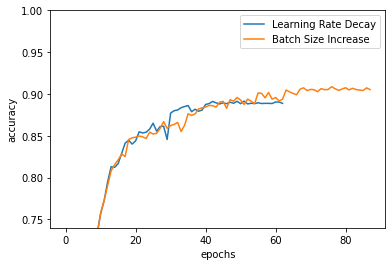

In [13]:
plt.plot(acc_history_LR,label="Learning Rate Decay")
plt.plot(acc_history_BS,label="Batch Size Increase")
plt.ylim((0.74,1.0))
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()